5.1.1 サイコロの目の和（分布モデル: 確率分布を使って期待値を計算）

In [3]:
ps = {2: 1/36, 3: 2/36, 4: 3/36, 5: 4/36, 6: 5/36, 7: 6/36, 8: 5/36, 9: 4/36, 10: 3/36, 11: 2/36, 12: 1/36} # 確率分布

V = 0
for x, p in ps. items():
    V += x*p
print(V) # 期待値

6.999999999999999


5.1.2-3 サンプルモデル: サンプルを使って期待値を計算

In [4]:
import numpy as np
def sample(dices=2):
    x = 0
    for _ in range(dices):
        x += np.random.choice([1, 2, 3, 4, 5, 6])
    return x

print(sample())
print(sample())
print(sample())

10
11
8


In [5]:
trial = 1000

samples = []
for _ in range(trial):
    s = sample()
    samples.append(s)

V = sum(samples) / len(samples) # 通常の平均計算

print(V)

7.129


In [6]:
trial = 1000
V, n = 0, 0

for _ in range(trial):
    s = sample()
    n += 1
    V += (s - V) / n # インクリメンタルな平均計算

print(V)

6.991000000000003


5.3.1 stepメソッドの使い方

In [7]:
from common.gridworld import GridWorld

env = GridWorld()
action = -3
next_state, reward, done = env.step(action)

print('next_state: ', next_state)
print('reward: ', reward)
print('done: ', done)

next_state:  (2, 0)
reward:  0
done:  False


エージェントクラスの実装

In [8]:
from collections import defaultdict


class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)
        self.cnts = defaultdict(lambda: 0) # 収益の平均計算時に使う母数
        self.memory = [] # (状態、行動、報酬)の保持

    # 各状態における方策に基づいて行動を確率的に決定する
    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    # まず方策に基づき一定回数の試行（エピソード）を重ねた後に評価が行われる
    def eval(self):
        G = 0
        for data in reversed(self.memory): # ゴール一歩手前から逆向きに経験をたどる（計算の効率化）
            state, action, reward = data
            G = self.gamma * G + reward # 割引率を適用した一個前の報酬と今回の報酬を合わせる
            self.cnts[state] += 1 # その状態を訪れた回数を記録
            self.V[state] += (G - self.V[state]) / self.cnts[state] # 価値観数（報酬の期待値）を更新

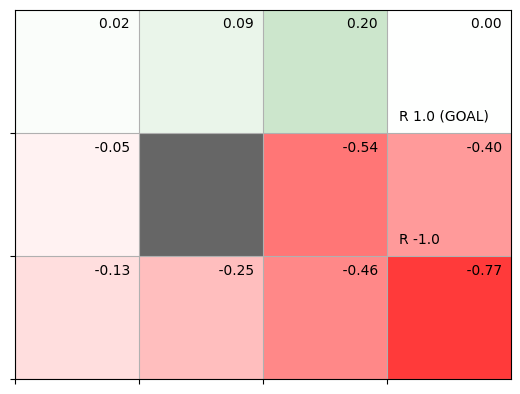

In [9]:
from common.gridworld import GridWorld

env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state) # 方策に基づいて行動を選択
        next_state, reward, done = env.step(action) # その行動から次の状態、報酬、ゴール確認を得る

        agent.add(state, action, reward) # 状態、報酬、ゴール確認の記録
        if done: # ゴールに着いたら
            agent.eval() # 状態価値関数を更新
            break

        state = next_state

env.render_v(agent.V)

5.4.5 モンテカルロ法を使った方策反復法

In [10]:
from collections import defaultdict
import numpy as np

class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs) # 方策の確率に従って行動を一つ選択

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory): # ゴール側から参照
            state, action, reward = data
            G = self.gamma * G + reward # 現在を除くゴール側までの報酬に割引率を当てた上で、現在の報酬を加える
            key = (state, action)
            self.Q[key] += (G - self.Q[key]) * self.alpha # 行動価値関数をインクリメント式に更新（過去（スタート側）のデータほど指数的に重みが小さくなる）
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon) #

def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)] # その状態における行動(0,1,2,3)の価値観数をリストに保持
    max_action = np.argmax(qs) # 最も値が高い価値観数の行動

    base_prob = epsilon / action_size # まず均等に探索確率を均等に割る(例えば0.1を４つの行動に均等分配してそれぞれ0.025)
    action_probs = {action: base_prob for action in range(action_size)} # 均等に割った探索確率を４つ全てに割り当てる
    action_probs[max_action] += (1 - epsilon) # その上に最も値が高い価値観数の行動には活用確率(0.9)も加える
    return action_probs # e.g. {0: 0.025, 1: 0.925, 2: 0.025, 3: 0.025}

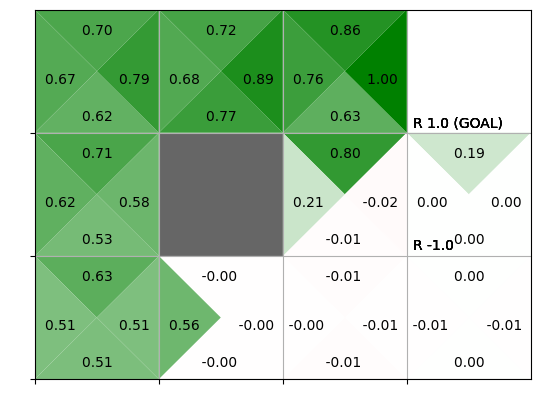

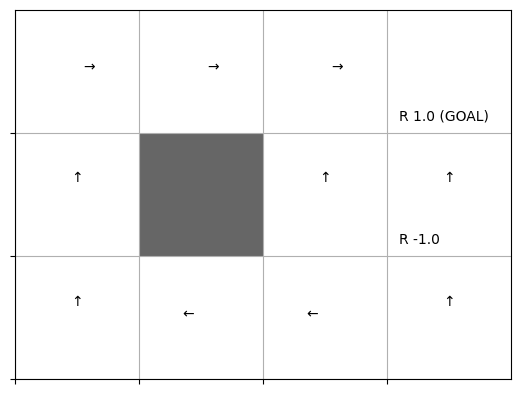

In [11]:
from common.gridworld import GridWorld

env = GridWorld()
agent = McAgent()
episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state) # 方策に基づいて行動を選択
        next_state, reward, done = env.step(action) # その行動によって得た状態、報酬、ゴール確認

        agent.add(state, action, reward) # 状態、報酬、ゴール確認の記録
        if done: # ゴールに着いたら
            agent.update() # 最も高い行動価値関数を優先した方策に更新
            break

        state = next_state

env.render_q(agent.Q)

5.5.2 重点サンプリング

In [12]:
import numpy as np

# 期待値
x = np.array([1, 2, 3])
pi = np.array([0.1, 0.1, 0.8])

e = np.sum(x * pi) # 期待値の定義式
print('E_pi[x]', e)

# モンテカルロ法による期待値（たくさん試行してその平均値を求める）
n = 100
samples = []
for _ in range(n):
    s = np.random.choice(x, p=pi)
    samples.append(s)

mean = np.mean(samples)
var = np.var(samples)
print('MC: {: .2f} (var: {:.2f})'.format(mean, var))

E_pi[x] 2.7
MC:  2.74 (var: 0.35)


In [13]:
# 重点サンプリング
x = np.array([1, 2, 3])
pi = np.array([0.1, 0.1, 0.8]) # ターゲット方策（活用：評価と改善）

b = np.array(([1/3, 1/3, 1/3])) # 挙動方策(探索：[状態、行動、報酬]をもたらすエージェントの行動選択)
n = 100
samples = []

for _ in range(n):
    idx = np.arange(len(b)) # [0, 1, 2]
    i = np.random.choice(idx, p=b) # 確率分布に従ってインデックス0,1,2をランダム選択
    s = x[i] # インデックスに対応した値(1,2,3)
    rho = pi[i] / b[i] # ターゲット方策π（活用）/ 挙動方策b(探索)　= 重みp(πで確率変数の確率が高いほど大きな重みになる)
    samples.append(s * rho) # 確率変数に重みpをかけて補正を掛ける（確率の高い変数ならその値が平均に与える影響度を大きくする）
    # e.g. 確率分布πにおいて変数3は0.8の確率だから、確率分布b[1/3,1/3,1/3]で出した変数3に2.4(0.8/(1/3))倍の補正を掛ける

mean = np.mean(samples)
var = np.var(samples)
print('IS: {:.2f} (var: {:.2f})'.format(mean, var))

IS: 3.15 (var: 10.95)


5.5.3 重点サンプリングにおける分散を小さくする方法

In [14]:
x = np.array([1, 2, 3])
pi = np.array([0.1, 0.1, 0.8]) # ターゲット方策（活用：評価と改善）

# ターゲット方策に分布を近づけると分散が小さくなる
b = np.array(([0.2, 0.2, 0.6])) # 挙動方策(探索：[状態、行動、報酬]をもたらすエージェントの行動選択)
n = 100
samples = []

for _ in range(n):
    idx = np.arange(len(b)) # [0, 1, 2]
    i = np.random.choice(idx, p=b) # 確率分布に従ってインデックス0,1,2をランダム選択
    s = x[i] # インデックスに対応した値(1,2,3)
    rho = pi[i] / b[i] # ターゲット方策π（活用）/ 挙動方策b(探索)　= 重みp(πで確率変数の確率が高いほど大きな重みになる)
    samples.append(s * rho) # 確率変数に重みpをかけて補正を掛ける（確率の高い変数ならその値が平均に与える影響度を大きくする）
    # e.g. 確率分布πにおいて変数3は0.8の確率だから、確率分布b[1/3,1/3,1/3]で出した変数3に2.4(0.8/(1/3))倍の補正を掛ける

mean = np.mean(samples)
var = np.var(samples)
print('IS: {:.2f} (var: {:.2f})'.format(mean, var))

IS: 2.78 (var: 2.45)


: 

A.2 方策オフ型のモンテカルロ法の実装

In [ ]:
import numpy as np
from common.gridworld import GridWorld
from common.utils import greedy_probs

class McOffPolucyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.2
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions) # 挙動方策
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.b[state] # その状態における挙動方策
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        rho = 1

        for data in reversed(self.memory):
            state, action, reward = data
            key = (state, action)

            G = self.gamma * rho * G + reward
            self.Q[key] += (G - self.Q[key]) * self.alpha
            rho *= self.pi [state][action] / self.b[state][action]

            self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
            self.b[state] = greedy_probs(self.Q, state, self.epsilon)
